# ALNS algorithms for Capacitated Vehicle Routing problem

### Reference
---
  - Lutz, Roman. "*Adaptive large neighborhood search.*" (2015).
  - Bent, Russell, and Pascal Van Hentenryck. "*A two-stage hybrid algorithm for pickup and delivery vehicle routing problems with time windows.*" Computers & Operations Research 33.4 (2006): 875-893.
---



In [1]:
import pandas as pd
import math
import random
import numpy as np
import copy
import xlsxwriter
import matplotlib.pyplot as plt

from tsplib95 import distances

In [2]:
%matplotlib inline

# CVRP
## Parameters Setup
- *rand_d_max*: max degree of random destruction
- *rand_d_min*: min degree of random destruction
- *worst_d_max*: max degree of worst destruction
- *worst_d_min*: min degree of worst destruction
- *regret_n*:  n next cheapest insertions
- *r1*: reward if the new solution is the best one found so far.
- *r2*: reward if the new solution improves the current solution.
- *r3*: reward if the new solution does not improve the current solution, but is accepted.
- *rho*: reaction factor of weight adjustments
- *phi*: the reduction factor of threshold acceptance
- *epochs*: Iterations
- *pu*: the number of iterations that are executed before an adjustment a.k.a update period
- *vehicle_cap*: Vehicle capacity
- *tol*: tolerance for threshold acceptance
- *opt_type*: Optimization 
    - type:0:Minimize the number of vehicles,
    - type:1:Minimize travel distance
<br>

#### Further Extensions and Adjustments
- Noising
- Penalties for time-intensive 


## Solution state

In [3]:
class Sol():
    def __init__(self):
        self.nodes_sequence=None
        self.obj=None
        self.routes=None

class Node():
    def __init__(self):
        self.id=0
        self.sequence_no=0
        self.coord = {}
        self.request=0

# Model
We need to set a model including all variables needed in the problem

### Degree of destruction parameters
![image info](./datatest/Degreeofdestruction.png "Degree of destruction")
<br>
The degree shouldn't be too large, otherwise the runtime of repair heuristics will increase dramatically.
<br>

### Acceptance method
The method used in this test is Threshold Acceptance (TA): <br>
The solution $s_0$ is accepted, if $c(s') - c(s) < T$ with a
threshold $T$. The threshold is decreased in every iteration by a factor $\phi$. <br>
#### Acceptance parameters
![image info](./datatest/accept.png) <br>
T is set so that the initially worst acceptable solution
has tol percent higher costs than the initial solution. 
$$T = tol · c(s_{init}).$$
Due to the book: the best solutions of the tuning were
found with Threshold Acceptance (TA), so for all further tunings, TA was used. The
best values for the reduction factor $\phi$ were between 0.9996 and 0.9998, so we
choose 0.9997. <br>The increase factor is not used by Threshold Acceptance, so it
did not occur in the results. The tolerance *tol* varied from 0.0075 to 0.0142 (From 0 to 0.3 as shown in table). A
value around one percent seems appropriate, so *tol* was fixed to 0.01 (We can set different values for testing).<br>

#### In weight adjustment
![image info](./datatest/weighttuning.png) <br><br>
According to the book, the most successful choice is : $r_1$ = 65, $r_2$ = 45, $r_3$ = 25. The reaction factor $\rho$ of the most successful configuration was at
0.35.

In [4]:
# Set value
rand_d_max=0.4
rand_d_min=0.1
worst_d_min=5
worst_d_max=20
related_d_min = 0
related_d_max = 0
regret_n=5
r1=65
r2=45
r3=25
rho=0.35
phi=0.9997
epochs=10
pu=5
vehicle_cap=80
opt_type=1
tol = 0.2

class Model():
    def __init__(self):
        self.best_sol=None
        self.node_list=[]
        self.node_seq_no_list=[]
        self.depot=None
        self.number_of_nodes=0
        self.opt_type=opt_type
        self.vehicle_cap = vehicle_cap
        self.distance = {}
        self.rand_d_max=rand_d_max
        self.rand_d_min=rand_d_min
        self.worst_d_max=worst_d_max
        self.worst_d_min=worst_d_min
        self.related_d_min = 0
        self.related_d_max = 0
        self.regret_n=regret_n
        self.r1=r1
        self.r2=r2
        self.r3=r3
        self.rho=rho
        self.d_weight=np.ones(2)*10
        self.d_select=np.zeros(2)
        self.d_score=np.zeros(2)
        self.d_history_select=np.zeros(2)
        self.d_history_score=np.zeros(2)
        self.r_weight=np.ones(3)*10
        self.r_select=np.zeros(3)
        self.r_score=np.zeros(3)
        self.r_history_select = np.zeros(3)
        self.r_history_score = np.zeros(3)

# Read data file


In [29]:
def readDataFile(filepath, model):
    # sep = separator in data file
    node_sequence_no = -1
    df = pd.read_csv(filepath, sep = "\t")
    for i in range(1,df.shape[0]):
        node = Node()
        node.id=node_sequence_no
        node.sequence_no=node_sequence_no
        node.coord = (df['x_coord'][i] , df['y_coord'][i])
        node.request=df['request'][i]
        if df['request'][i] == 0:
            model.depot=node
        else:
            model.node_list.append(node)
            model.node_seq_no_list.append(node_sequence_no)

        node.id=df['id'][i]
        node_sequence_no=node_sequence_no + 1
    model.number_of_nodes=len(model.node_list)

model = Model()
readDataFile('../ALNS-VRP problems/datatest/ALNS_CVRP.txt', model)

# Initial Parameter

In [6]:
def dis_between_points(p1, p2): 
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2) 

# Create a distance matrix between points
def initParam(model):
    for i in range(model.number_of_nodes):
        for j in range(i+1,model.number_of_nodes):
            dis = dis_between_points(model.node_list[i].coord,model.node_list[j].coord)
            # print(dis)
            model.distance[i,j]=dis
            model.distance[j,i]=dis
            

initParam(model)

## Initial Solution Construction


In [7]:

def genInitialSol(node_sequence):
    node_sequence = copy.deepcopy(node_sequence)
    random.seed(0) # To make sure 
    random.shuffle(node_sequence) # Reorder node_sequence (The index of nodes)
    return node_sequence

# Minimizing the number of vehicles since we don't have any information about them
def splitRoutes(nodes_sequence,model):
    num_vehicle = 0
    vehicle_routes = []
    route = []
    remained_cap = model.vehicle_cap

    for node_no in nodes_sequence:
        if remained_cap - model.node_list[node_no].request >= 0:
            route.append(node_no)
            remained_cap = remained_cap - model.node_list[node_no].request
        else:
            vehicle_routes.append(route)
            route = [node_no]
            num_vehicle = num_vehicle + 1
            remained_cap =model.vehicle_cap - model.node_list[node_no].request
    vehicle_routes.append(route)
    
    return num_vehicle,vehicle_routes

# print(genInitialSol(model.node_seq_no_list))


# Calculate Function

In [8]:
def calDistance(route,model):
    distance=0
    depot=model.depot
    for i in range(len(route)-1):
        distance+=model.distance[route[i],route[i+1]]
    first_node=model.node_list[route[0]]
    last_node=model.node_list[route[-1]]
    distance+=dis_between_points(depot.coord, first_node.coord)
    distance+=dis_between_points(depot.coord, last_node.coord)
    return distance
    
def calObj(nodes_sequence,model):
    num_vehicle, vehicle_routes = splitRoutes(nodes_sequence, model)
    if model.opt_type==0:
        return num_vehicle,vehicle_routes
    else:
        distance=0
        for route in vehicle_routes:
            distance+=calDistance(route,model)
        return distance,vehicle_routes

# Destroy Operators
### Random Removal
The idea in Random Removal is pretty simple. It creates diversification in heuristic. <br>
Actually, the interval for remove list is [0.1 · n, 0.4 · n] for instances with a low number of requests and it is [30, 60] for larger instances. For the instances in the tuning, n is either 50 or 100, so the former alternative would be chosen.

In [9]:
def createRandomDestory(model):
    #Select a random degree of destruction from [dmin,dmax] in every iteration.
    d=random.uniform(model.rand_d_min,model.rand_d_max)
    remove_list=random.sample(range(model.number_of_nodes),int(d*model.number_of_nodes))
    # Remove randomly d*model.number_of_nodes nodes 
    
    # For larger instances
    # remove_list=random.sample(min(range(model.number_of_nodes),30),min(int(d*model.number_of_nodes), 60))
    return remove_list

### Worst Removal 
The idea of worst removal is to remove the worst parts of the solution, i.e. those that cause the biggest costs, hoping that the repair
heuristic is able to eliminate the huge costs. <br>
Our mission is calculating the difference of the costs of the solution and the costs of the solution without that part.<br>
The worst removal is more or less the same as random removal, but the difference is that the list is sorted in ascending order.<br>
<br>
After calculating all the differences, we can take a sets of $d$ elements (which have the biggest cost) to destroy and repair heuristic.<br> 
Note: $d$ acctually can be constant but ultilize the process, we can choose it randomly in the range of degree.


In [10]:
def createWorstDestory(model,sol):

    diff=[]
    for node_no in sol.nodes_sequence:
        nodes_sequence=copy.deepcopy(sol.nodes_sequence)
        nodes_sequence.remove(node_no)
        obj,vehicle_routes=calObj(nodes_sequence,model)
        # Take difference if remove node_no in nodes_sequence
        diff.append(sol.obj - obj)

    sorted_id = sorted(range(len(diff)), key=lambda k: diff[k], reverse=True)
    #Select a random degree of destruction from [dmin,dmax] in every iteration.
    d=random.randint(model.worst_d_min,model.worst_d_max)
    # Take first d index of largest differences in nodes_sequence
    remove_list = sorted_id[:d]
    
    return remove_list

### Related Removal

In [11]:
def largestdistance(model):
    return np.max(model.distance)

def largestrequest(model):
    max = -9999999999999999
    for i in range(model.number_of_nodes):
        if model.node_list[i].request > max:
            max = model.node_list[i].request
    return max

def calRel(model):
    # Relatedness Value
    relVal = 0

    return relVal

# Largest distance between two points
LarDis = largestdistance(model)

def createRelatedDestory(model, sol):
    number_remove = min(model.number_of_nodes, random.randint(int(model.number_of_nodes*model.related_d_max), 
                                                 int(model.number_of_nodes*model.related_d_min)))

    random_no = random.uniform(0, len(sol.nodes_sequence))
    remove_list = []
    remove_list.append(random_no)
    sol.nodes_sequence.remove(sol.nodes_sequence[random_no])
    number_remove -= 1

    rel = []
    while number_remove > 0:
        nodes_sequence=copy.deepcopy(sol.nodes_sequence)
        random_no = random.uniform(0, len(nodes_sequence))
        for node_no in sol.nodes_sequence:
            if node_no != random_no:
                RelVal = model.varphi*model.distance[random_no, node_no]/LarDis + \
                        model.psi*(abs(model.node_list[random_no] - model.node_list[node_no]))
            else:
                continue
            nodes_sequence.remove(node_no)
        
        number_remove -= 1
        # Take difference if remove node_no in nodes_sequence
        


IndentationError: expected an indented block after function definition on line 4 (1017058176.py, line 7)

## Repair Operators
### Random Rapair
Random repair is just for getting repair id if its value is 0.


In [ ]:
def createRandomRepair(remove_list,model,sol):
    unassigned_nodes_seq =[]
    assigned_nodes_seq = []
    # remove node from current solution
    for i in range(model.number_of_nodes):
        if i in remove_list:
            unassigned_nodes_seq.append(sol.nodes_sequence[i])
        else:
            assigned_nodes_seq.append(sol.nodes_sequence[i])
    # insert
    for node_no in unassigned_nodes_seq:
        index = random.randint(0,len(assigned_nodes_seq)-1)
        assigned_nodes_seq.insert(index,node_no)
    new_sol=Sol()
    new_sol.nodes_sequence = copy.deepcopy(assigned_nodes_seq)
    new_sol.obj,new_sol.routes = calObj(assigned_nodes_seq,model)
    return new_sol

### Greedy Repair heuristic
Basic Greedy Repair determines the cheapest insertion position for all currently unserved requests.<br>
First step is find the position to add element to assigned list from remove list. <br>
The rule is simple: Add the smallest different cost.

In [ ]:
def findGreedyInsert(unassigned_nodes_seq,assigned_nodes_seq,model):
    best_insert_node_no = None
    best_insert_index = None
    best_insert_cost = float(9999999999999999999999999)
    # We only need to take assigned_nodes_seq_obj
    assigned_nodes_seq_obj, _ = calObj(assigned_nodes_seq,model)
    for node_no in unassigned_nodes_seq:
        for i in range(len(assigned_nodes_seq)):
            new_assigned_nodes_seq = copy.deepcopy(assigned_nodes_seq)
            new_assigned_nodes_seq.insert(i, node_no)
            obj, _ = calObj(new_assigned_nodes_seq, model)
            diff = obj - assigned_nodes_seq_obj
            if diff<best_insert_cost:
                best_insert_index = i
                best_insert_node_no = node_no
                best_insert_cost = diff
    return best_insert_node_no,best_insert_index


def createGreedyRepair(remove_list,model,sol):
    unassigned_nodes_seq = []
    assigned_nodes_seq = []
    
    # remove node from current solution
    for i in range(model.number_of_nodes):
        if i in remove_list:
            unassigned_nodes_seq.append(sol.nodes_sequence[i])
        else:
            assigned_nodes_seq.append(sol.nodes_sequence[i])
    #insert
    while len(unassigned_nodes_seq)>0:
        insert_node_no,insert_index = findGreedyInsert(unassigned_nodes_seq,assigned_nodes_seq,model)
        assigned_nodes_seq.insert(insert_index,insert_node_no)
        unassigned_nodes_seq.remove(insert_node_no)

    new_sol=Sol()
    new_sol.nodes_sequence=copy.deepcopy(assigned_nodes_seq)
    new_sol.obj,new_sol.routes=calObj(assigned_nodes_seq,model)
    return new_sol

### Regret Repair
Regret Repair takes an approach that is similar to Basic Greedy Repair. But instead of inserting the requests at the cheapest position, a Regret-n heuristic calculates a regret value based on $s_i(r)$, a modification of the current solution s, in which request r has been inserted in the i-cheapest tour. <br><br>
In general, a Regret-n heuristic calculates the part with the greatest cost difference between the cheapest and the n - 1 next cheapest insertions. The next insertion candidate can be determined by
$$\argmax_{r \in R^-} \biggl\{\sum_{i=1}^{n}(c(s_i(r)) - c(s_1(r))) \biggl\}  (*)$$
Here, R- stands for the set of currently unassigned requests (*unassigned_nodes_seq*)
#### Repair Heuristic Parameters
About param value, there can possibly be an arbitrary number of Regret Repair heuristics (Regret_n) .<br><br>
![image info](./datatest/regret.png) <br><br>
The noise , i.e a random number from an interval whose length is influenced by $\eta$, is added to the cost increase values in the
repair heuristics. In the special case η = 0, no noise is used at all. The three best configurations had a $\eta$ value
of 0.4238, 0.4268 and 0.4700 (As the book said).

In [ ]:
def findRegretInsert(unassigned_nodes_seq,assigned_nodes_seq,model):
    opt_insert_node_no = None
    opt_insert_index = None
    opt_insert_cost = -float(9999999999999999999999999)
    for node_no in unassigned_nodes_seq:
        # Create a matrix size 3 x len(assigned_nodes_seq)
        n_insert_cost = np.zeros((len(assigned_nodes_seq),3))
        for i in range(len(assigned_nodes_seq)):
            new_assigned_nodes_seq = copy.deepcopy(assigned_nodes_seq)
            new_assigned_nodes_seq.insert(i,node_no)
            obj, _ = calObj(new_assigned_nodes_seq,model)
            n_insert_cost[i,0]=node_no
            n_insert_cost[i,1]=i
            n_insert_cost[i,2]=obj
            
        n_insert_cost= n_insert_cost[n_insert_cost[:, 2].argsort()]
        
        diff=0
        for i in range(1,model.regret_n):
            diff +=  n_insert_cost[i,2] - n_insert_cost[0,2]
        # Here the (*) :
        if diff>opt_insert_cost:
            opt_insert_node_no = int(n_insert_cost[0, 0])
            opt_insert_index = int(n_insert_cost[0,1])
            opt_insert_cost = diff
    return opt_insert_node_no,opt_insert_index


def createRegretRepair(remove_list,model,sol):
    unassigned_nodes_seq = []
    assigned_nodes_seq = []
    # remove node from current solution
    for i in range(model.number_of_nodes):
        if i in remove_list:
            unassigned_nodes_seq.append(sol.nodes_sequence[i])
        else:
            assigned_nodes_seq.append(sol.nodes_sequence[i])
    # insert
    while len(unassigned_nodes_seq)>0:
        insert_node_no,insert_index=findRegretInsert(unassigned_nodes_seq,assigned_nodes_seq,model)
        assigned_nodes_seq.insert(insert_index,insert_node_no)
        unassigned_nodes_seq.remove(insert_node_no)
        
    new_sol = Sol()
    new_sol.nodes_sequence = copy.deepcopy(assigned_nodes_seq)
    new_sol.obj, new_sol.routes = calObj(assigned_nodes_seq, model)
    return new_sol
# sol = Sol()
# sol.nodes_sequence = genInitialSol(model.node_seq_no_list)
# remove_list = createRandomDestory(model)
# createRegretRepair(remove_list,model,sol)

## Destroy and Repair to do
Repair and destroy heuristic in each iteration are chosen from sets of heuristics due to the probability depended on weights (The probability equation is shown below)

In [ ]:
def doDestory(destory_id,model,sol):
    if destory_id==0:
        remove_list=createRandomDestory(model)
    else:
        remove_list=createWorstDestory(model,sol)
    return remove_list

def doRepair(repair_id,remove_list,model,sol):
    if repair_id==0:
        new_sol=createRandomRepair(remove_list,model,sol)
    elif repair_id==1:
        new_sol=createGreedyRepair(remove_list,model,sol)
    else:
        new_sol=createRegretRepair(remove_list,model,sol)
    return new_sol


## Weight Scheme
Actually, the weight reflects heuristic's success.<br>
The selection of a heuristic in each iteration is then based on these weights.<br>\
Let $D = \{d_i|i = 1,...,k\}$ be the set of k destroy heuristics and
$S = \{r_i|i = 1,...,l\}$ be the set of l repair heuristics. The initially equal weights
of the heuristics are denoted by $w(r_i)$ and $w(d_i)$ <br>
The probabilities to select a heuristic: 
$$p(r_i)=\frac{w(r_i)}{\sum_{j=1}^{k} w(r_i)}, p(d_i)=\frac{w(d_i)}{\sum_{j=1}^{l} w(d_i)}$$
(That is cumulative sum)

In [ ]:
def selectDestoryRepair(model):
    d_weight=model.d_weight
    d_prob = np.cumsum(d_weight / sum(d_weight))
    d_prob -= np.random.rand()
    destory_id = None
    for d_no in range(len(d_prob)):
        if d_prob[d_no] > 0: 
            destory_id = d_no
            break

    r_weight=model.r_weight
    r_prob = np.cumsum(r_weight / sum(r_weight))
    r_prob -= np.random.rand()
    repair_id = None
    for r_no in range(len(r_prob)):
        if r_prob[r_no] > 0: 
            repair_id = r_no
            break

    return destory_id,repair_id


### Weights Updating
Adjusting the weights of the heuristics is necessary in order to increase the probability that successful heuristics are used more often than less successful heuristics for a specific problem instance. The dynamic adjustments are the only way to ensure permanent re-evalution of the heuristics.<br>
Our approach is to execute $p_u$ iterations of the algorithm and adjust the weights afterwards. <br><br>
We need to determine the weight adjustment $w(h)$ ($w(h)$ denotes the weight of a heuristic $h$).
We calculate the weights for the following iterations by
$$M = \biggl\{\begin{array}{cc} 
(1-\rho)w(h) + \rho \frac{s(h)}{u(h)}, & \text{if u(h) > 0}\\
(1-\rho)w(h) , & \text{if u(h) = 0}
\end{array}$$
The weights of destroy and repair heuristic is calculated independently. <br>
Note: 
- $s(h)$ stands for the success of solution. In here, we define it as score.
- $u(h)$ is the number of times the heuristic $h$ has been used during the $p_u$ iterations.
- The reaction factor $\rho$ controls the influence of the recent success of a heuristic on its weight. <br>
<br>


In [ ]:
def resetScore(model):

    model.d_select = np.zeros(2)
    model.d_score = np.zeros(2)

    model.r_select = np.zeros(3)
    model.r_score = np.zeros(3)

# Reaction factor rho
def updateWeight(model):
    for i in range(model.d_weight.shape[0]):
        if model.d_select[i]>0:
            model.d_weight[i] = model.d_weight[i]*(1-model.rho) + (model.rho*model.d_score[i]/model.d_select[i])
        else:
            model.d_weight[i] = model.d_weight[i] * (1 - model.rho)
    for i in range(model.r_weight.shape[0]):
        if model.r_select[i]>0:
            model.r_weight[i] = model.r_weight[i]*(1-model.rho) + (model.rho*model.r_score[i]/model.r_select[i])
        else:
            model.r_weight[i] = model.r_weight[i] * (1 - model.rho)
            
    model.d_history_select = model.d_history_select + model.d_select
    model.d_history_score = model.d_history_score + model.d_score
    model.r_history_select = model.r_history_select + model.r_select
    model.r_history_score = model.r_history_score + model.r_score

## Data

In [ ]:
def plotObj(obj_list):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(np.arange(1,len(obj_list)+1),obj_list)
    plt.xlabel('Iterations')
    plt.ylabel('Obj Value')
    plt.grid()
    plt.xlim(1,len(obj_list)+1)
    plt.show()

## Output


In [ ]:
def run(filepath,rand_d_max,rand_d_min,worst_d_min,worst_d_max,regret_n,r1,r2,r3,rho,phi,epochs,pu,vehicle_cap,opt_type):
    
    model=Model()
    model.rand_d_max=rand_d_max
    model.rand_d_min=rand_d_min
    model.worst_d_min=worst_d_min
    model.worst_d_max=worst_d_max
    model.regret_n=regret_n
    model.r1=r1
    model.r2=r2
    model.r3=r3
    model.rho=rho
    model.vehicle_cap=vehicle_cap
    model.opt_type=opt_type
    ##
    readDataFile(filepath, model)
    initParam(model)
    ##
    history_best_obj = []
    sol = Sol()
    sol.nodes_sequence = genInitialSol(model.node_seq_no_list)
    sol.obj, sol.routes = calObj(sol.nodes_sequence, model)
    model.best_sol = copy.deepcopy(sol)
    history_best_obj.append(sol.obj)
    for ep in range(epochs):
        # Parameter tolerance:  tol can be chosen in range of [0, 0.3]. 
        tol = 0.2
        T = sol.obj*tol
        resetScore(model)
        for k in range(pu):
            destory_id,repair_id = selectDestoryRepair(model)
            model.d_select[destory_id] += 1
            model.r_select[repair_id] += 1
            remove_list = doDestory(destory_id,model,sol)
            new_sol = doRepair(repair_id,remove_list,model,sol)
            if new_sol.obj < sol.obj:
                sol = copy.deepcopy(new_sol)
                if new_sol.obj<model.best_sol.obj:
                    model.best_sol = copy.deepcopy(new_sol)
                    model.d_score[destory_id] += model.r1
                    model.r_score[repair_id] += model.r1
                else:
                    model.d_score[destory_id] += model.r2
                    model.r_score[repair_id] += model.r2
            elif new_sol.obj-sol.obj < T:
                sol=copy.deepcopy(new_sol)
                model.d_score[destory_id] += model.r3
                model.r_score[repair_id] += model.r3
            # The threshold is decreased in every iteration by a factor phi  
            T=T*phi
            print("%s/%s:%s/%s,  Best heuristic objective: %s" % (ep,epochs,k,pu, model.best_sol.obj))
            history_best_obj.append(model.best_sol.obj)
        updateWeight(model)
        
    plotObj(history_best_obj)

    print("random removal weight is {:.3f}\tselect is {}\tscore is {:.3f}".format(model.d_weight[0],
                                                                        model.d_history_select[0],
                                                                        model.d_history_score[0]))
    print("worst removal weight is {:.3f}\tselect is {}\tscore is {:.3f} ".format(model.d_weight[1],
                                                                        model.d_history_select[1],
                                                                        model.d_history_score[1]))
    print("random repair weight is {:.3f}\tselect is {}\tscore is {:.3f}".format(model.r_weight[0],
                                                                       model.r_history_select[0],
                                                                       model.r_history_score[0]))
    print("greedy repair weight is {:.3f}\tselect is {}\tscore is {:.3f}".format(model.r_weight[1],
                                                                       model.r_history_select[1],
                                                                       model.r_history_score[1]))
    print("regret repair weight is {:.3f}\tselect is {}\tscore is {:.3f}".format(model.r_weight[2],
                                                                       model.r_history_select[2],
                                                                       model.r_history_score[2]))


## Input place

0/20:0/5,  Best heuristic objective: 4682.553799539461
0/20:1/5,  Best heuristic objective: 3998.9717037545493
0/20:2/5,  Best heuristic objective: 3998.9717037545493
0/20:3/5,  Best heuristic objective: 3485.324174849033
0/20:4/5,  Best heuristic objective: 3162.679060869262
1/20:0/5,  Best heuristic objective: 2928.2192524992365
1/20:1/5,  Best heuristic objective: 2928.2192524992365
1/20:2/5,  Best heuristic objective: 2740.263351524533
1/20:3/5,  Best heuristic objective: 2697.531076014119
1/20:4/5,  Best heuristic objective: 2697.531076014119
2/20:0/5,  Best heuristic objective: 2697.531076014119
2/20:1/5,  Best heuristic objective: 2697.531076014119
2/20:2/5,  Best heuristic objective: 2697.531076014119
2/20:3/5,  Best heuristic objective: 2628.8303755423162
2/20:4/5,  Best heuristic objective: 2628.8303755423162
3/20:0/5,  Best heuristic objective: 2628.8303755423162
3/20:1/5,  Best heuristic objective: 2590.210363614335
3/20:2/5,  Best heuristic objective: 2539.401811074311
3/2

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


19/20:4/5,  Best heuristic objective: 2327.207764512148


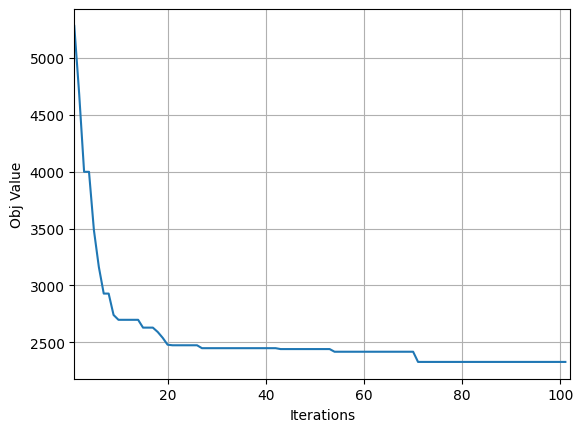

random removal weight is 25.131	select is 24.0	score is 655.000
worst removal weight is 38.108	select is 76.0	score is 3280.000 
random repair weight is 0.004	select is 2.0	score is 25.000
greedy repair weight is 35.699	select is 49.0	score is 1965.000
regret repair weight is 32.468	select is 49.0	score is 1945.000


In [ ]:
Filee = '../ALNS-VRP problems/datatest/ALNS_CVRP.txt'
rand_d_max=0.4
rand_d_min=0.1
worst_d_min=5
worst_d_max=20
regret_n=5
#Score
r1=65
r2=45
r3=25
# Reaction factor of action weight
rho=0.35
# Reduction factor of threshold acceptance
phi=0.9997
# Set number of epochs
epochs=20
# The number of iterations that are executed before an adjustment a.k.a update period
pu=5
vehicle_cap=80
# Optimization type
opt_type=1
tol = 0.2

run(Filee, rand_d_max, rand_d_min, worst_d_min, worst_d_max, regret_n, r1, r2, r3, rho,
    phi, epochs, pu, vehicle_cap, opt_type)